## FIR Filter Design

In this notebook, we'll look into a fairly simple method of designing a finite impulse response (FIR) filter. Although the method itself is straightforward, the way we get there is not entirely intuitive. But it's really worth digging into a few of the details and it will highlight the relevance of several of the concepts we've learned so far.

In [1]:
# Import the necessary packages as usual
%pip install ipympl
import numpy as np 
import scipy as sp
from scipy import signal
import io
from scipy.io import wavfile
from pyodide.http import pyfetch
from matplotlib import pyplot as plt
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
%matplotlib ipympl

# function for reading WAV files from a URL. Must be a RAW link, not GitHub HTML
speech_sample = "https://raw.githubusercontent.com/randyaliased/acspjbook/main/book/audio/F2.wav"
impulse_resp = "https://raw.githubusercontent.com/randyaliased/acspjbook/main/book/audio/IR1.wav"

async def read_wav_from_url(url):
    response = await pyfetch(url)
    wav_bytes = await response.bytes()  # get raw binary
    fs, data = wavfile.read(io.BytesIO(wav_bytes))

    # convert to float in [-1, 1]
    if np.issubdtype(data.dtype, np.integer):
        max_val = np.iinfo(data.dtype).max
        data = data.astype(np.float32) / max_val
    else:
        data = data.astype(np.float32)  # already float
    
    return data, fs

### Recalling the DTFT

In our notebook on frequency analysis of discrete-time signals, we briefly mentioned the [discrete-time Fourier transform (DTFT)](https://randyaliased.github.io/acspjbook/main/fundamental/07_DFT.html#discrete-time-fourier-transform-dtft) (note this is not the discrete Fourier transform (DFT)). For a discrete-time signal, $h[n]$, the DTFT was given by 

$$\begin{align} 
	H(f) &= \sum\limits_{n=-\infty}^{\infty}h[n]e^{-j \frac{2 \pi f}{f_s} n}
\end{align}$$

where $H(f)$ is the Fourier transform of $h[n]$ that is continuous in frequency, $f$, (Hz) (recall that $H(f)$ will be complex-valued) and $f_{s}$ is the sampling frequency (Hz). Note that we can equivalently write this in terms of the angular frequency (radians/second), $\omega = 2 \pi f$, but we will keep things in terms of frequency (Hz). And of course, we can also go the other way around, i.e., given $H(f)$, we can recover the discrete-time signal, $h[n]$ via the inverse DTFT:

$$\begin{align} 
	h[n] &= \frac{1}{f_{s}} \int\limits_{-f_{s}/2}^{f_{s}/2}H(f)e^{j \frac{2 \pi f}{f_s} n} df
\end{align}$$

This gives us a convenient starting point for designing digital filters. If it is that we have some ideal frequency response specified by $H(f)$, then we can obtain the filter coefficients in the time-domain by doing an inverse DTFT.


### A low-pass filter

Let's consider the design of a simple low-pass finite impulse response (FIR) filter, with an ideal frequency response as depicted in Fig. 1. This filter can be mathematically defined such that

$$\begin{equation}
H(f) = \begin{cases} 1  & |f| \leq f_{c}\\ 
                     0  & |f| > f_{c} \end{cases}
\end{equation}$$

where $f_{c}$ is the cut-off frequency in Hz, so that there is a "pass-band gain" of $1$ between $-f_{c}$ and $f_{c}$, and zero elsewhere, hence preserving the frequency content up to the cut-off frequency (thus a low-pass filter). Note that we are considering the entire double-sided spectrum that is symmetrical around $0$ Hz (see the [DFT notebook](https://randyaliased.github.io/acspjbook/main/fundamental/07_DFT.html) for a refresher on this).

<br>

<div>
<center> <img src="ideal_lpfilt.png" width="550"/> <center/>
    <p style="text-align:center">Fig. 1 - Ideal low-pass filter </p>
</div>

<br>

In order to get the **impulse response**, $h[n]$ corresponding to this filter, we use the inverse DTFT. I'm going to leave this as an exercise for you (you'll have to make use of [Euler's identity](https://randyaliased.github.io/acspjbook/main/fundamental/02_Complex_numbers.html#euler-s-identity)). If you've done it correctly, you should end up with the following expression:

$$\begin{equation}
h[n] = \frac{1}{n \pi} \sin\left(\frac{2 \pi f_{c} n}{f_{s}}\right)
\end{equation}$$

which holds for $n = -\infty$ to $\infty$, i.e., it is an infinite impulse response (IIR). A more convenient expression is to write $h[n]$ in terms of a sinc function (which we encountered when looking at [windows](https://randyaliased.github.io/acspjbook/main/fundamental/08_Windows.html#rectangular-boxcar-window)).

$$\begin{align}
h[n] &= \frac{1}{n \pi} \sin\left(\frac{2 \pi f_{c} n}{f_{s}}\right) \\
     &= 2 \frac{f_{c}}{f_{s}} \frac{\sin\left(\frac{2 \pi f_{c} n}{f_{s}}\right)}{\frac{2 \pi f_{c} n}{f_{s}}} \\
     &= 2 \frac{f_{c}}{f_{s}}  \text{sinc}\left(\frac{2 \pi f_{c} n}{f_{s}}\right)  
\end{align}$$

where the unnormalized sinc function is defined as

$$\begin{equation}
\text{sinc}(x) = \begin{cases} 1 \hspace{1.6cm} x = 0 \\
                        \sin(x)/x \hspace{0.5cm} x \neq 0\end{cases}
\end{equation}$$

**Please keep in mind** that there is also a [normalized version of the sinc function](https://en.wikipedia.org/wiki/Sinc_function) which includes a factor of $\pi$. Be very careful with this as different texts/programming languages may choose either version. For instance [the sinc function in Python](https://numpy.org/doc/stable/reference/generated/numpy.sinc.html) uses the normalized version.

Let's plot the filter coefficients, $h[n]$ to get an idea of how this looks. We'll change the cutoff frequency, $f_c$ to see how the filter coefficients change.

Adjust fc to see how the filter coefficients change


interactive(children=(IntSlider(value=100, description='fc', max=300, min=50), Output()), _dom_classes=('widge…

<function __main__.interactive_sinc(fc=100)>

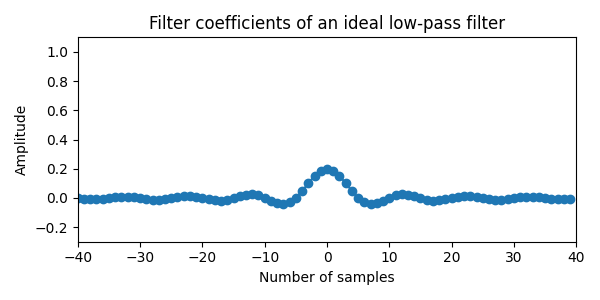

In [ ]:
# Setting up the sinc function parameters
fs = 1000                     # let's assume some sampling frequency in Hz
ws = 2*np.pi*fs               # angular frequency

n = np.arange(-40,40,1)          # sample index array

fig, ax = plt.subplots(figsize=(6,3))

h_plot, = ax.plot([], [],'-o') 

ax.set_xlabel('n')
ax.set_ylabel('Amplitude')
ax.set_title('Filter coefficients of an ideal low-pass filter')
ax.set_xlim([-40, 40])
ax.set_ylim([-0.3,1.1])


# Interactive plot
def interactive_sinc(fc=100):
	
    fig.canvas.draw_idle()
    h = 2*(fc/fs)*np.sinc((2*fc/fs)*n)   # filter coefficients
    h_plot.set_data(n, h)
    
plt.tight_layout()
    
print("Adjust fc to see how the filter coefficients change")
interact(interactive_sinc, fc=(50, 300, 1))


### A windowed FIR filter

Okay so this is great, we now have an analytical expression for $h[n]$, i.e., we have an impulse response for our ideal low-pass filter for any $f_{c}$ and $f_{s}$ we choose. Now it's should just be a matter of doing a convolution between some input signal, $x[n]$ and the filter coefficients, $h[n]$ to obtain a low-pass filtered version of our input signal! But unfortunately there are still two practical issues:

1. The expression for $h[n]$ holds for $n = -\infty$ to $\infty$, which means that we need an infinite number of filter coefficients to filter our input signal in accordance with the ideal low-pass filter. To make an FIR version of the filter, we must truncate the IIR filter to a finite number of coefficients somehow.

2. The filter in its current form is **acausal**, i.e., the outputs of the filter depend on future input samples.

Let's firstly tackle the problem of truncating the filter. We define an FIR **filter order**, $P$, as a truncation that yields $N = P+1$ coefficients. The number, $N$ is also referred to as the filter length or the number of *taps* in the FIR filter. A straight forward way to truncate the filter is to simply select some set of samples of the filter before and after $n=0$ such that the symmetry of the filter is preserved. So for instance, we may choose the coefficients: $h[-10], h[-9], h[-8], \dots, h[0], \dots, h[8], h[9], h[10]$, giving us 21 samples and hence an FIR filter of order 20. This in fact corresponds to applying a rectangular window of 21 samples that is centred around $h[0]$.

Hence a more mathematically elegant and general way to truncate the FIR filter is to multiply $h[n]$ by a [symmetrical window](https://randyaliased.github.io/acspjbook/main/fundamental/08_Windows.html#), $w[n]$. Hence a windowed FIR filter, $h_{w}[n]$ of order $P$ can be obtained as

$$\begin{equation}
h_{w}[n] = h[n] w[n] \hspace{0.5cm} -P/2 \leq n \leq P/2
\end{equation}$$

### Impact of windowing on the ideal low-pass filter

The burning question at this point is how does truncating the FIR filter with the window affect the ideal low-pass characteristic? Well we can start to understand this by considering the DTFT of $h_{w}[n]$ which is given by

$$\begin{align} 
	H_{w}(f) &= \sum\limits_{n=-\infty}^{\infty}h[n] w[n] e^{-j \frac{2 \pi f}{f_s} n}
\end{align}$$

This only holds for the limits of n between $-\infty$ and $+\infty$, whereas when we truncate we will have the finite set of samples between $-P/2 \leq n \leq P/2$. But let's continue with a bit of reasoning using the DTFT with infinite samples.

Let's sidestep for a minute and recall what is perhaps one of the most important results in all of signal processing: the **convolution theorem**. This states that the Fourier transform of a convolution between two time-domain signals is equivalent to the product of their respective Fourier transforms. Considering our two signals, $h[n]$ and $w[n]$, mathematically this is expressed as:

$$\begin{align}
\sum\limits_{n=-\infty}^{\infty} (h[n] * w[n]) e^{-j \frac{2 \pi f}{f_s} n} &=  \sum\limits_{n=-\infty}^{\infty} h[n] e^{-j \frac{2 \pi f}{f_s} n} \sum\limits_{n=-\infty}^{\infty} w[n] e^{-j \frac{2 \pi f}{f_s} n} \\
&= H(f) W(f)
\end{align}$$

where the operator $*$ represents a convolution. The **converse is also true** -- the Fourier transform of a product between two time-domain signals is equivalent to the convolution of their respective Fourier transforms, so that

$$\begin{align}
\sum\limits_{n=-\infty}^{\infty} (h[n] w[n]) e^{-j \frac{2 \pi f}{f_s} n} &=  \sum\limits_{n=-\infty}^{\infty} h[n] e^{-j \frac{2 \pi f}{f_s} n} * \sum\limits_{n=-\infty}^{\infty} w[n] e^{-j \frac{2 \pi f}{f_s} n} \\
H_{w}(f) &= H(f) * W(f)
\end{align}$$

which tells us exactly how the windowing affects the ideal low-pass filter. In words, the frequency response of the windowed FIR filter will be the result of a convolution between the ideal low-pass filter and the frequency response of the window we use. Recall from the [notebook on convolution](https://randyaliased.github.io/acspjbook/main/dasp/01_IR_Conv.html) we visualized what a convolution looked like - one of the signals time-reversed and sliding over the other, multiplying both signals at each shift index and summing the result. The same thing is happening here except in the frequency domain. Hence the frequency response of the window is really critical for how the ideal low-pass filter will be affected. 

When we consider the finite set of samples between $-P/2 \leq n \leq P/2$, the only difference is that instead of the DTFT, we need to transition to the [discrete Fourier transform (DFT)](https://randyaliased.github.io/acspjbook/main/fundamental/07_DFT.html#discrete-fourier-transform-dft) and consider the spectrum sampled at $k f_{s}/N$ for $k = -P/2, -P/2 + 1, \dots, 0, \dots, P/2 - 1, P/2$, and where $N = P + 1$ is the total number of samples. Hence we will have the DFT of $h_{w}[n]$ as

$$\begin{align} 
	H_{w}[k] &= \sum\limits_{n=-P/2}^{P/2}h_{w}[n] e^{-j \frac{2 \pi n k}{N}} \\
             &= \sum\limits_{n=-P/2}^{P/2}h[n] w[n] e^{-j \frac{2 \pi n k}{N}} \\
             &= \sum\limits_{n=-P/2}^{P/2}h[n] e^{-j \frac{2 \pi n k}{N}} * \sum\limits_{n=-P/2}^{P/2} w[n] e^{-j \frac{2 \pi n k}{N}} \\
             &= H[k] * W[k]
\end{align}$$

Note that the convolutions here are between two sequences of complex numbers. 

Let's plot all of this to get a better idea of what's really happening. This is a fairly dense plot and it's worth spending some time playing around with it and then going back to the math to make sure everything checks out and makes sense. Some details regarding the plot:

1. The left column are the signals in the time-domain, and the right column their corresponding DFT magnitudes.

2. In the upper-left figure, we plot both the "ideal" FIR filter, $h[n]$ and the corresponding window, $w[n]$, to truncate it. There is a **slider to (i) change the type of window, and (ii) to change the order of the truncated filter.** Note that in this figure, $h[n]$ was normalized just to visualize it better (otherwise its amplitude was lower, making it diffcult to see it). The normalized signal was not used in computations.

3. The bottom-left figure shows the result of the truncation by the window yielding the signal $h_{w}[n]$.

4. The upper-right figure shows the DFT magnitudes, $H[k]$ and $W[k]$. In this plot $W[k]$ is now normalized just to visualize it better, and this normalized version was not used in computations. There is also a **third slider which controls the shifting of $W[k]$** in order to visualize the convolution process.

5. The lower-right figure shows (i) the DFT magnitude of $h_{w}[n]$, $H_{w}[k]$ and (ii) the result of the convolution as the slider controlling the shifting of $W[k]$ is changed. The two dotted grey vertical lines also show $-f_{c}$ and $f_{c}$. We can see that the convolution traces out exactly the DFT magnitude response $H_{w}[k]$, which gives us insight into how the ideal low-pass filter characteristic we started with is being affected by the window. For instance, we see that the transition from the pass band to the stop band is not always as instantaneous as the ideal filter and it some cases there are ripples in the pass band of the low-pass filter. 

Adjust the sliders below to observe the effect of window type, order, and frequency shift on the filter design process.


interactive(children=(IntSlider(value=100, description='Order', max=180, min=20, step=2), IntSlider(value=0, d…

<function __main__.interactive_fir(Order=100, win_type=0, k_shift=-200)>

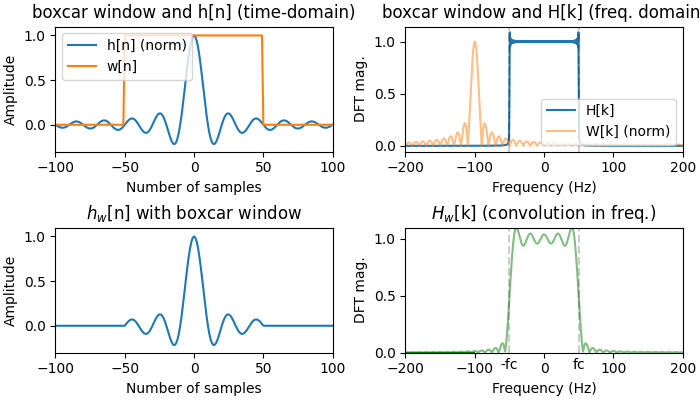

In [ ]:
# Interactive plot to show the windowed-FIR design process

# Setting up the sinc function parameters
fs = 1000                     # let's assume some sampling frequency in Hz
fc = 50                       # cutoff frequency in Hz
ws = 2*np.pi*fs               # angular frequency

n = np.arange(-1000,1000,1)     # sample index for sinc
x_sinc = 2*(fc/fs)*np.sinc((2*fc/fs)*n)   # sinc function

# DFT of sinc function
X_sinc = np.fft.fft(x_sinc)
freq = (np.fft.fftfreq(len(x_sinc), d=1/fs)) 
# This is a sorting of the frequencies/DFT coefficients so they go from negative to positive freq.
sort_ind = np.argsort(freq) 
freq = freq[sort_ind]
X_sinc = X_sinc[sort_ind]
X_sinc_mag = np.abs(X_sinc)


# We'll use the signal.get_window function to obtain the windows.
# Add more to this list as you wish from the available ones: 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.get_window.html#scipy.signal.windows.get_window

window_types = ['boxcar', 'hann', 'blackman', 'hamming', 'flattop'] 


# PLOTS
fig, ax = plt.subplots(2,2, figsize=(7,4),constrained_layout=True)

# Time domain plots
timesinc, = ax[0,0].plot(n, x_sinc/np.max(x_sinc), label = 'h[n] (norm)') # normalizing just to visualize it better (not used in computations)
timewin, = ax[0,0].plot([],[], label='w[n]')
ax[0,0].set_xlabel('n')
ax[0,0].set_ylabel('Amplitude')
ax[0,0].set_xlim([-100, 100])
ax[0,0].set_ylim([-0.3,1.1])
ax[0,0].legend(loc='upper left')

windowedplot, = ax[1,0].plot([], [])
ax[1,0].set_xlabel('n')
ax[1,0].set_ylabel('Amplitude')
ax[1,0].set_xlim([-100, 100])
ax[1,0].set_ylim([-0.3,1.1])

# Freq domain plots
dftmag, = ax[0,1].plot(freq, X_sinc_mag,'-', label='H[k]')
dftmag_win, = ax[0,1].plot([], [], '-', label='W[k] (norm)',alpha=0.5)
ax[0,1].axvline(fc, color='k', linestyle='--',alpha=0.2)
ax[0,1].axvline(-fc, color='k', linestyle='--',alpha=0.2)
ax[0,1].set_xlabel('Frequency (Hz)')
ax[0,1].set_ylabel('DFT mag.')
ax[0,1].set_xlim([-200,200])
# ax[0,1].set_ylim([0, 10.1])
ax[0,1].legend(loc='lower right')

dft_win_sinc, = ax[1,1].plot([], [], 'g-',alpha=0.5)
conv_out, = ax[1,1].plot([],[],'g-')
ax[1,1].axvline(fc, color='k', linestyle='--',alpha=0.2)
ax[1,1].axvline(-fc, color='k', linestyle='--',alpha=0.2)
ax[1,1].text(fc, -0.8*ax[1,1].get_ylim()[1], "fc", va='top', ha='center')
ax[1,1].text(-fc, -0.8*ax[1,1].get_ylim()[1], "-fc", va='top', ha='center')
ax[1,1].set_title('$H_{w}$[k] (convolution in freq.)')
ax[1,1].set_xlabel('Frequency (Hz)')
ax[1,1].set_ylabel('DFT mag.')
ax[1,1].set_xlim([-200,200])
ax[1,1].set_ylim([0, 1.1])


# For convolution output
y_conv = np.zeros(len(X_sinc_mag))
tmp_sample_idx = np.arange(-200,200,1)



# Interactive plot
def interactive_fir(Order=100, win_type=0, k_shift=-200):
	
    fig.canvas.draw_idle()

    # Time-domain plots
    # Get window and plot it
    win = signal.get_window(window_types[win_type], Order) # get window
    win_signal = np.zeros(len(x_sinc)) # ends of window will be zero
    win_signal[(len(n)//2 - Order//2):(len(n)//2 + Order//2)] = win # put window in the middle of the zero array
    timewin.set_data(n, win_signal)
    ax[0,0].set_title(window_types[win_type]+' window and h[n] (time-domain)')

    # windowed sinc
    x_win_sinc = x_sinc * win_signal
    windowedplot.set_data(n, x_win_sinc/np.max(x_win_sinc))
    ax[1,0].set_title('$h_{w}$[n] with ' + window_types[win_type]+' window')

    # Freq-domain plots

    # DFT of window

    X_win = np.fft.fft(win_signal)
    # This is a sorting of the frequencies/DFT coefficients so they go from negative to positive freq.
    X_win = X_win[sort_ind]
    X_win_mag = np.abs(X_win)
    X_win_mag_norm = X_win_mag/np.max(X_win_mag) # normalizing just to visualize it better (not used in computations)
    X_win_mag_shift = np.roll(X_win_mag_norm,k_shift) # shifting for visualization
    dftmag_win.set_data(freq, X_win_mag_shift) 
    ax[0,1].set_title(window_types[win_type]+' window and H[k] (freq. domain)')



    # DFT of windowed sinc
    X_win_sinc = np.fft.fft(x_win_sinc) 
    X_win_sinc = X_win_sinc[sort_ind]   
    X_win_sinc_mag = np.abs(X_win_sinc)
    dft_win_sinc.set_data(freq, (X_win_sinc_mag))

    # Convolution in freq. domain
    for i in tmp_sample_idx:
        X_shift = np.roll(X_win,i)
        y_conv[len(X_sinc_mag)//2 + i] = np.abs((X_sinc@X_shift))/len(X_sinc)  # compute inner product

    conv_out.set_data(freq[0:(len(X_sinc_mag)//2 + k_shift)], y_conv[0:(len(X_sinc_mag)//2 + k_shift)])
    
    
print("Adjust the sliders below to observe the effect of window type, order, and frequency shift on the filter design process.")
interact(interactive_fir, Order=(20, 180, 2), win_type=(0, len(window_types)-1, 1), k_shift=(-200, 200, 1))


### Causality

Now that we've understood how to truncate the FIR filter with a window, the last issue we need to resolve is the acausal nature of the FIR filter. Let's consider a simple case of a 2nd order filter, where we have obtained the following 3 coefficients:

$$\begin{align}
h_{w}[-1] &= 0.2 \\ 
h_{w}[0] &= 0.5 \\
h_{w}[1] &= 0.2  
\end{align}$$

and we want to filter some input signal, $x[n]$, then the output, $y[n]$ is given by the following convolution

$$\begin{align}
y[n] &= \sum_{k} x[n-k] h_{w}[k] \\
     &= h_{w}[-1]x[n+1] +  h_{w}[0]x[n] + h_{w}[1]x[n-1] \\
     & = 0.2 x[n+1] +  0.5 x[n] + 0.2 x[n-1]
\end{align}$$

When $n = 0$, we can observe that there will be a dependence on the value $x[1]$, i.e., the output is dependent upon an input that occurs in the future! This is why we consider this filter as **acausal** and cannot be implemented in practice.

The simple way to make the filter **causal** is to simply delay it such that the output only depends on current and past samples. In this case, we can delay the filter by one sample so that:

$$\begin{align}
h_{w}[0] &= 0.2 \\ 
h_{w}[1] &= 0.5 \\
h_{w}[2] &= 0.2  
\end{align}$$

and hence 

$$\begin{align}
y[n] &= \sum_{k} x[n-k] h_{w}[k] \\
     &= h_{w}[0]x[n] +  h_{w}[1]x[n-1] + h_{w}[2]x[n-2] \\
     & = 0.2 x[n] +  0.5 x[n-1] + 0.2 x[n-2]
\end{align}$$

### Summarizing the Windowed-FIR design

We can now summarize the windowed FIR design as follows:

1. Obtain the impulse response coefficients from the inverse DTFT of the ideal frequency response of your filter.
2. Apply a window to the infinite impulse response.
3. Delay the impulse response so all non-zero samples have non-negative indices (this will make the filter causal).
4. Get the FIR filter coefficients from the causal impulse response.
5. Filter your input signal.